In [1]:
%cd ..

/Users/udeepa/Documents/UCL/Term 2/numerical/svm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import time

# from opt.svm import SVC
from opt.utils.data_splitter import split4ovr, split4ovo

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

### Dataset

In [3]:
# Load data
data = np.load('data/dummy/filtered_mnist.npz')
x_train = data['a']
y_train = data['b']
x_test  = data['c']
y_test  = data['d']
print("Number of training samples:       ", len(y_train))
print("Distribution of training samples: ", Counter(y_train))
print("Number of test samples:           ", len(y_test))
print("Distribution of training samples: ", Counter(y_test))

Number of training samples:        12665
Distribution of training samples:  Counter({1: 6742, 0: 5923})
Number of test samples:            2115
Distribution of training samples:  Counter({1: 1135, 0: 980})


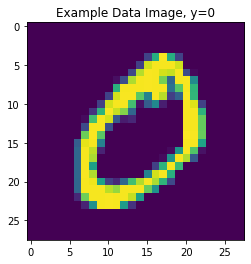

In [4]:
# Visualise data
imx, imy = (28,28)
visual = np.reshape(x_train[0], (imx,imy))
plt.title("Example Data Image, y="+str(int(y_train[0])))
plt.imshow(visual, vmin=0, vmax=1)

### SVM Model

In [5]:
import numpy as np
from scipy import stats
import time

from opt.utils.kernels import polynomial_kernel_matrix, gaussian_kernel_matrix

class SVC:
    """
    Multiclass soft-margin kernelised SVM.  
    """
    def __init__(self, C=1.0, kernel="gauss", param=0.5, decision_function_shape="ovo", 
                 loss_fn='L1', opt_algo="smo"):
        """
        Arguments:
        ----------
        C : `float`
            Regularization parameter. The strength of the regularization is 
            inversely proportional to C. Must be strictly positive. 
            The penalty is a squared l2 penalty.
        kernel : `str`
            The Kernel to use. {'poly', 'gauss'}.
        param : `float`
            Parameter of the kernel chosen, 
            i.e. the degree if polynomial or the gamma is gaussian. 
        decision_function_shape : `str`
            The method for multiclass classification. {'ovo','ovr'}.
        loss_fn : `str`
            The loss function for the optimisation problem. {'L1','L2'}.
        opt_algo : `str`
            The optimisation method to use. {'barrier', 'smo'}.
        """         
        self.C = float(C)
        self.kernel = kernel
        self.param = param
        self.decision_function_shape = decision_function_shape
        self.loss_fn = loss_fn
        self.opt_algo = opt_algo
        self.classifiers = dict()
        
    def fit(self, X, y):
        """
        Function to train the SVM.
        
        Parameters:
        -----------
        X : `dict` of `numpy.ndarray` or `numpy.ndarray`
             if self.decision_function_shape="ovo":
                 Dictionary of all the kchoose2 datasets for the classifiers.
                (nData, nDim) matrix of data.
             if self.decision_function_shape="ova"
                 (nData, nDim) matrix of data.
        y : `dict` of `numpy.ndarray`
             if self.decision_function_shape="ovo":
                 Dictionary of labels for the kchoose2 classifiers.
                (nData,) matrix of corresponding labels. Each element is in the set {-1,+1}.
             if self.decision_function_shape="ova"
                 Dictionary of labels for the k classifiers.
                (nData,) matrix of corresponding labels. Each element is in the set {-1,+1}.
        """
        if self.decision_function_shape == "ovo":
            for key, val in X.items():
                # Get kernel matrix
                if self.kernel == "poly":
                    kernel_martix = polynomial_kernel_matrix(val, val, 0, self.param)
                elif self.kernel == "gauss":
                    kernel_martix = gaussian_kernel_matrix(val, val, self.param)                
                self.classifiers[key] = SVM(self.C)
                self.classifiers[key].fit(val, y[key], kernel_matrix, self.loss_fn, self.opt_algo)                   
                
        elif self.decision_function_shape == "ovr":
            # Get kernel matrix
            if self.kernel == "poly":
                kernel_martix = polynomial_kernel_matrix(X, X, 0, self.param)
            elif self.kernel == "gauss":
                kernel_martix = gaussian_kernel_matrix(X, X, self.param) 
            for key, val in y.items():
                self.classifiers[key] = SVM(self.C)
                self.classifiers[key].fit(X, val, kernel_martix, self.loss_fn, self.opt_algo)                             
        
    def predict(self, X):
        """
        Predict on test set.
        
        Parameters:
        -----------
        X : `numpy.ndarray`
            (nData, nDim) matrix of test data. Each row corresponds to a data point.  
            
        Returns:
        --------
        yhats : `numpy.ndarray`
            (nData,) List of predictions on the test data.
        """        
        # Create matrix (nClassifiers, nTestData) 
        predictions = np.zeros((self.nClassifiers, X.shape[0]))
        if self.decision_function_shape == "ovo":
            for i, (key, val) in enumerate(self.classifiers.items()):
                yhats = np.sign(val.predict(X))
                # Convert predictions labels to digits.
                predictions[i,:] = self.convert_labels2digits(yhats, int(key[0]), int(key[-1]))
            # Return the mode label for each test data point.
            # If there is more than one such value, only the smallest is returned.
            return np.squeeze(stats.mode(predictions, axis=0)[0])
       
        elif self.decision_function_shape == "ovr":
            for i, (key, val) in enumerate(self.classifiers.items()):
                predictions[i,:] = val.predict(X)
            # Return the label with the highest value.    
            return np.argmax(predictions, axis=0)            
        
    @staticmethod
    def convert_labels2digits(yhats, pos_label, neg_label):
        """
        Functions that maps +1 to the positive class label 
        and -1 to the negative class label.
        
        Parameters:
        -----------
        yhats : `numpy.ndarray`
            The predictions from the classifier.
        pos_label : `int`
            The positive class label.
        neg_label : `int`
            The negative class label.
            
        Returns:
        --------
        digits : `numpy.ndarray`
            The predicitions mapped to the class labels +1 -> pos_labels, -1 -> neg_labels.
        """
        return np.where(yhats==1, pos_label, neg_label)        

In [6]:
class SVM:
    """
    Soft-margin kernalised SVM base class
    """
    def __init__(self, C=1.0):
        """
        Arguments:
        ----------
        C : `float`
            Regularization parameter. The strength of the regularization is 
            inversely proportional to C. Must be strictly positive. 
            The penalty is a squared l2 penalty.    
        """        
        self.C = float(C)
        
    def fit(self, X, y, kernel_matrix, loss_fn, opt_algo):
        """
        TODO: Function to fit SVM.
        
        min 0.5x^TPx + q^Tx
        s.t. Gx <= h
             Ax = b        
        
        Parameters:
        -----------
        X : `numpy.ndarray`
            (nData, nDim) matrix of data. Each row corresponds to a data point.
        y : `numpy.ndarray`
            (nData,) matrix of corresponding labels. Each element is in the set {-1,+1}.
        kernel_matrix : `numpy.ndarray`
            (nData, nData) Kernel matrix of training data.  
        loss_fn : `str`
            The loss function for the optimisation problem. {'L1','L2'}.            
        opt_algo : `str`
            The optimisation method to use. {'barrier', 'smo'}.
        """ 
        info = dict()
        
        # Convert data to floats
        X = X.astype(float)
        y = y[:,None].astype(float)
        n, d = X.shape
        
        # Parameters of optimisation problem
        if loss_fn == 'L1':
            P = y@y.T*kernel_matrix
            q = -np.ones((n,1))
            G = np.vstack((-np.eye(n), 
                            np.eye(n)))
            h = np.vstack((np.zeros((n,1)), 
                           self.C*np.ones((n,1))))
            A = y.T
            b = np.zeros(1)    
        elif loss_fn == 'L2':
            P = y@y.T*(kernel_matrix + 1/self.C * np.eye(n))
            q = -np.ones((n,1))
            G = -np.eye(n)
            h = np.zeros((n,1))
            A = y.T
            b = np.zeros(1)  
        
        # Optimisation        
        if opt_algo == "barrier":      
            # Interior point barrier method specific parameters
            x0 = np.zeros((n,1)) # TODO: Need feasible starting point  
            t  = 1               # TODO: Choice of t            
            mu = 20
            tol = 1e-3
            max_iter = 100              
            # Solve
            start_time = time.time()
            lambdas, f_min, t, nIter, info = barrier_method(P, q, G, h, A, b, x0, t, mu, tol, max_iter)      
            time_taken = time.time()-start_time
        elif opt_algo == "smo":
            # Sequential minimal optimisation method specific parameters
            x0 = np.zeros((n,1)) 
            tol = 1e-3
            max_iter = 100               
            pass            
            
        # Support vectors have non-zero lambdas
        S  = np.logical_and(lambdas>1e-5, lambdas<=self.C).flatten()
        MS = np.logical_and(lambdas>1e-5, lambdas<self.C).flatten()
        self.lambdas = lambdas[S]
        self.sv   = X[S]
        self.sv_y = y[S] 
        # Get intercept
        self.bias = np.mean(y[MS] - ((lambdas[MS]*y[MS]).T@kernel_matrix[MS][:,MS]).T)        

    def predict(self, X):
        """
        Predict on test set.
        
        Parameters:
        -----------
        X : `numpy.ndarray`
            (nData, nDim) matrix of test data. Each row corresponds to a data point.              
            
        Returns:
        --------
        yhats : `numpy.ndarray`
            (nData,) List of predictions on the test data, not corresponding to labels {-1,+1}
            Need to take np.sign() after.
        """               
        # Get kernel matrix between support vectors and test data
        if self.kernel == "poly":
            kernel_matrix = polynomial_kernel_matrix(self.sv, X, 0, self.param)
        elif self.kernel == "gauss":
            kernel_matrix = gaussian_kernel_matrix(self.sv, X, self.param) 
        return np.squeeze((self.alphas*self.sv_y).T@kernel_matrix + self.bias)

### Optimisation Algorithm 1: Interior Points

In [7]:
from opt.algos.descent import feasible_newtonLS
from opt.algos.linesearch import backtracking
from opt.algos.interior_point import FeasibleNewtonCENT

def barrier_method(P, q, G, h, A, b, x0, t, mu, tol, max_iter):
    """
    Barrier method 
    
    Parameters:
    -----------
    P : `numpy.ndarray`
        (d,d) 
    q : `numpy.ndarray`
        (d,1)    
    G : `numpy.ndarray`
        (m,d) matrix from inequality constraints.
    h : `numpy.ndarray`
        (m,1)            
    A : `numpy.ndarray`
        (p,d) matrix from equality constraint. 
    b : `numpy.ndarray`
            (p,1)
    x0 : `numpy.ndarray`
        Initial iterate.
    t : `float`
        Parameter for barrier.    
    mu : `float`
        Increase factor for t.
    tol : `float`
        tolerance on the (duality gap ~ m/t)
    max_iter : `int`
        Maximum number of iterations.
    
    Returns:
    --------
    x_min : `numpy.ndarray`
        Minimum of objective function F
    f_min : `float`
        Value of minimum objective function F
    nIter : `int`
        Number of iterations.
    info : `dict` of `list`
        Information about iteration.
    """
    # Initialisation
    nIter = 0
    stopCond = False
    x_k = x0
    F = FeasibleNewtonCENT(P, q, G, h, A, b, t)
    
    print("F.F.f:   ", F.F.f(x0).shape)
    print("F.F.df:  ", F.F.df(x0).shape)
    print("F.F.d2f: ", F.F.d2f(x0).shape)
    print("F.phi.f:   ", F.phi.f(x0).shape)
    print(F.phi.f(x0))
    print("F.phi.df:  ", F.phi.df(x0).shape)
#     print("F.phi.d2f: ", F.phi.d2f(x0).shape)
    
    return 0
    
    info = defaultdict(list)
    info['xs'].append(x_k)
    info['fs'].append(F.f(x_k))
    info['inIter'].append(0)
    info['dGap'].append(1/t)
    
    # Parameters for centering step
    m = G.shape[0] 
    alpha0 =1
    c1  = 1e-4
    c2  = 0.9
    rho = 0.5
    tolNewton = 1e-12
    maxIterNewton = 100
    
    while stopCond is False and nIter < max_iter:
        # Create function handler for centering step 
        # (needs to be redefined at each step because of changing "t")
        F = FeasibleNewtonCENT(P, q, G, h, A, b, t)
        
        # Line search function (needs to be redefined at each step because of changing F) 
        lsFun = lambda F, x_k, p_k, alpha0: backtracking(F, x_k, p_k, alpha0, rho, c1)
        # Centering step
        x_k, f_k, nIterLS, infoLS = feasible_newtonLS(F, lsFun, alpha0, x_k, tolNewton, maxIterNewton)   
        
        # Check stopping condition (m/t).
        if m/t < tol: 
            stopCond = True

        # Increase t
        t *= mu

        # Store info
        info['xs'].append(x_k)
        info['fs'].append(f_k)
        info['inIter'].append(nIterLS)
        info['dGap'].append(1/t)

        # Increment number of iterations
        nIter += 1
    
    return x_k, F.f(x_k), t, nIter, info

In [8]:
def feasible_newtonLS(F, ls, alpha0, x0, tol, max_iter):
    """
    Feasible Newton method: Newton method which starts at a feasible point 
    and subsequently enforces the equality constraints on the step maintaining feasibility.
    Reference: Algorithm 10.1 from Boyd, Convex Optimization.
    
    Parameters:
    -----------
    F : `function`
        Objective function.
    ls : `function`
        Specifies line search algorithm.
    alpha0 : `float`
        initial step length.
    x0 : `numpy.ndarray`
        (d,1) Feasible initial iterate.
    tol : `float`
        Stopping condition on minimal allowed step.
    max_iter : `int`
        Maximum number of iterations.
    
    Returns:
    --------
    x_min : `numpy.ndarray`
        Minimum of objective function F
    f_min : `float`
        Value of minimum objective function F
    nIter : `int`
        Number of iterations.
    info : `dict` of `list`
        Information about iteration.       
    """  
    # Initialisation
    nIter = 0
    x_k = x0
    d = x0.shape[0]
    info = defaultdict(list)
    info['xs'].append(x0)
    info['alphas'].append(alpha0)   
    
    # Loop until convergence or maximum number of iterations
    while True:
        # Increment iterations
        nIter += 1
        
        # Compute descent direction
        p_k = -np.linalg.pinv(F.d2f(x_k))@F.df(x_k) # Newton direction
        if p_k.T@F.df(x_k)>0:
            # Force to be descent direction (only active if F.d2f(x_k) not pos.def.)
            p_k = -p_k       
        # Get Newton step
        delta_x_k = p_k[:d,:]
        
        # Stopping condition
        # Compute Newton decrement
        lambda_k = (-delta_x_k.T@F.d2f(x_k)[:d,:d]@delta_x_k)**0.5
        if 0.5*lambda_k**(2) <= tol:
            break     
            
        # Call line search given by handle ls for computing step length
        alpha_k = ls(F, x_k, delta_x_k, alpha0)            
        # Update x_k
        x_k = x_k + alpha_k*delta_x_k               
        
        # Store iteration info
        info['xs'].append(x_k)
        info['alphas'].append(alpha_k)
            
    return x_k, F.f(x_k), nIter, info

### Optimisation Algorithm 2: SMO

### Optimisation Algorithm 3: Coordinate Descent

### Main

In [9]:
svm = SVC(C=1.0, 
          kernel="gauss", 
          param=0.5, 
          decision_function_shape="ovr",
          loss_fn='L1',
          opt_algo="barrier")

# Train: OVO
x_train_ovo, y_train_ovo = split4ovo(x_train, y_train)
# svm.fit(x_train_ovo, y_train_ovo)

# Train: OVR
y_train_ovr = split4ovr(y_train)
svm.fit(x_train, y_train_ovr)

# # Test
# yhat = svm.predict(x_test)

F.F.f:    ()
F.F.df:   (12665, 1)
F.F.d2f:  (12665, 12665)
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
F.phi.f:    ()


/Users/udeepa/Documents/UCL/Term 2/numerical/svm/opt/algos/interior_point.py:202: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(self.h - self.G@x))


[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
inf


/Users/udeepa/Documents/UCL/Term 2/numerical/svm/opt/algos/interior_point.py:216: RuntimeWarning: divide by zero encountered in true_divide
  tmp = 1 / (self.h - self.G@x)
/Users/udeepa/Documents/UCL/Term 2/numerical/svm/opt/algos/interior_point.py:217: RuntimeWarning: invalid value encountered in matmul
  return self.G.T@tmp


F.phi.df:   (12665, 1)


TypeError: 'int' object is not iterable

In [16]:
X = x_train.astype(float)
y = y_train_ovr["0"][:,None].astype(float)
n, d = X.shape
kernel_matrix = gaussian_kernel_matrix(X, X, 0.5)   
C = 1
x0 = np.zeros((n,1))

P = y@y.T*kernel_matrix
q = -np.ones((n,1))
G = np.vstack((-np.eye(n), 
                np.eye(n)))
h = np.vstack((np.zeros((n,1)), 
               C*np.ones((n,1))))
A = y.T
b = np.zeros(1)  

In [17]:
np.sum(np.log(h - G@x0))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf